<a href="https://colab.research.google.com/github/bbombver/dataviz2025/blob/main/Final_Project_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **กลุ่มที่ 2**

# Looker Studio

https://lookerstudio.google.com/s/nRLGdKn3ypU

**สมาชิก**

```
1. นางสาวกัลย์สุดา กองโพธิ์,653020201-9
2. นางสาวชญาดา ภาษาเวทย์,663020581-4
3. นางสาวบุณยนุช อินทวงษ์,663020582-2
4. นายวชิรวิทย์ มูลละออง,663020584-8
5. นางสาวไอวรินทร์ ชื่นแสน,663020587-2
6. นายกฤตนัย  วิเศษคร้อ,663020620-0
```


# โค้ดรวม ทั้งหมด ทุกส่วน

In [ ]:
import pandas as pd
import os
from google.colab import drive
from IPython.display import display

# --- 1. ส่วนสำหรับเชื่อมต่อ Google Drive และ Google Sheets ---
print("กำลังเชื่อมต่อ Google Drive...")
drive.mount('/content/drive')

# นำเข้าไลบรารีสำหรับ Google Sheets และทำการยืนยันตัวตน
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe

print("กำลังเชื่อมต่อ Google Sheets API...")
creds, _ = default()
gc = gspread.authorize(creds)
print("เชื่อมต่อสำเร็จ!")

# --- 2. ฟังก์ชันสำหรับอ่านข้อมูล (เพิ่มคอลัมน์ 'Month') ---
def read_all_data(base_path):
    all_dfs = []
    if not os.path.exists(base_path):
        print(f"Error: ไม่พบโฟลเดอร์ที่ '{base_path}'")
        return None

    months = sorted(os.listdir(base_path)) # ใช้ sorted() เพื่อเรียงลำดับ

    for month in months:
        month_path = os.path.join(base_path, month)
        if os.path.isdir(month_path):
            files = os.listdir(month_path)
            for file in files:
                if 'stop-and-search' in file and file.endswith('.csv'):
                    filepath = os.path.join(month_path, file)
                    df = pd.read_csv(filepath)

                    # --- เพิ่มคอลัมน์ 'Month' และ 'Police Force' ---
                    df['Month'] = month  # เพิ่มคอลัมน์เดือน (เช่น '2025-01')
                    city = file.replace(f"{month}-", '').replace('-stop-and-search.csv', '')
                    df['Police Force'] = city # นำชื่อเมืองมาสร้างคอลัมน์ใหม่

                    all_dfs.append(df)
    return all_dfs

# --- 3. ฟังก์ชันสำหรับแปลงช่วงอายุ ---
# สร้าง Dictionary สำหรับการแปลงค่า
age_replacement_map = {
    '10-17': 14,
    '18-24': 21,
    '25-34': 30,
    'over 34': 34,
    'under 10': 10
}

# สร้างฟังก์ชันเพื่อทำการแปลงค่า
def recode_age_range(dataframe):
    if 'Age range' in dataframe.columns:
        dataframe['Age range'] = dataframe['Age range'].replace(age_replacement_map)
    else:
        print("Warning: คอลัมน์ 'Age range' ไม่พบใน DataFrame นี้")
    return dataframe

# --- 4. เริ่มกระบวนการเตรียมข้อมูล (Data Preparation) ---

print("\n--- เริ่มกระบวนการเตรียมข้อมูล ---")

# 4.1. กำหนด Path และเรียกใช้งานฟังก์ชัน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
list_of_all_dataframes = read_all_data(base_path)

if list_of_all_dataframes:
    # 4.2. รวม DataFrame ทั้งหมดให้เป็นไฟล์เดียว
    combined_df = pd.concat(list_of_all_dataframes, ignore_index=True)
    print("✨ รวมไฟล์ทั้งหมดสำเร็จ!")
    print(f"จำนวนข้อมูลทั้งหมด: {combined_df.shape[0]} แถว, {combined_df.shape[1]} คอลัมน์")

    # 4.3. แปลงช่วงอายุ
    combined_df = recode_age_range(combined_df)
    print("🔄 แปลงข้อมูล 'Age range' เป็นค่าตัวเลขเรียบร้อยแล้ว")

    # --- 4.3a. ทำให้ 'Age range' เป็นจำนวนเต็ม (ลบทศนิยม) ---
    # Convert 'Age range' to numeric, coercing errors to NaN
    combined_df['Age range'] = pd.to_numeric(combined_df['Age range'], errors='coerce')
    # Now fill NaN values with 'Unknown'
    combined_df['Age range'].fillna('Unknown', inplace=True)

    print("🔄 แปลง 'Age range' เป็นจำนวนเต็ม (Integers) เรียบร้อยแล้ว")


    # 4.4. เติมค่าว่าง (Missing Values)
    # Fill remaining NaNs in other columns with 'Unknown'
    combined_df.fillna('Unknown', inplace=True)
    print("🔄 เติมค่าว่าง (NaN/<NA>) ทั้งหมดด้วย 'Unknown' เรียบร้อยแล้ว")

    # --- 4.4a. ปรับปรุงคอลัมน์ 'Month' ---
    combined_df['Month'] = combined_df['Month'].str.split('-').str[-1]
    print("🔄 ปรับปรุงคอลัมน์ 'Month' (เอาปีออก) เรียบร้อยแล้ว")

    # 4.5. จัดการคอลัมน์ 'Date' และ 'Time' (แยก, ลบ, เปลี่ยนชื่อ)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')
    combined_df['Date Only'] = combined_df['Date'].dt.date
    combined_df['Time'] = combined_df['Date'].dt.time

    cols = combined_df.columns.tolist()
    cols.remove('Date Only')
    cols.remove('Time')
    date_index = cols.index('Date')
    cols.insert(date_index + 1, 'Date Only')
    cols.insert(date_index + 2, 'Time')
    combined_df = combined_df[cols]
    combined_df = combined_df.drop('Date', axis=1)
    combined_df = combined_df.rename(columns={'Date Only': 'Date'})
    print("🔄 แยกและจัดเรียงคอลัมน์ Date และ Time เรียบร้อยแล้ว")

    # --- 4.5a. (เพิ่มใหม่) แปลงชื่อ Police Force ให้เป็นทางการ ---
    print("🔄 กำลังแปลงชื่อ Police Force ให้เป็นทางการ...")
    combined_df['Police Force'] = combined_df['Police Force'].str.replace('-', ' ').str.title()

    # แก้ไขชื่อพิเศษสำหรับทำแผนที่
    special_names_map = {
        'Metropolitan': 'Greater London',  # โปรแกรมแผนที่จะเข้าใจ 'Greater London'
        'Btp': 'British Transport Police'
    }
    combined_df['Police Force'] = combined_df['Police Force'].replace(special_names_map)
    print("🔄 แปลงชื่อ Police Force เรียบร้อยแล้ว (เช่น 'south-yorkshire' -> 'South Yorkshire')")


    # --- 4.6. จัดเรียงคอลัมน์ใหม่ ---
    print("🔄 กำลังจัดเรียงคอลัมน์ใหม่ ('Type', 'Police Force', 'Month'...)")
    all_cols = combined_df.columns.tolist()

    # คอลัมน์ที่ต้องการย้ายไปข้างหน้า
    front_cols = ['Type', 'Police Force', 'Month']

    # สร้าง list ใหม่โดยเอา 3 คอลัมน์นี้ออกก่อน
    remaining_cols = [col for col in all_cols if col not in front_cols]

    # สร้างลำดับใหม่
    new_column_order = front_cols + remaining_cols
    combined_df = combined_df[new_column_order]
    print("🔄 จัดเรียงคอลัมน์ใหม่เรียบร้อยแล้ว")

    # 4.7. แสดงผลลัพธ์สุดท้ายก่อนบันทึก
    print("\n✅ กระบวนการเตรียมข้อมูลเสร็จสมบูรณ์ ✅")
    print("ตัวอย่าง 5 แถวสุดท้ายของข้อมูลที่เตรียมเสร็จแล้ว:")
    display(combined_df.head())
    print(f"มิติข้อมูลสุดท้าย: {combined_df.shape[0]} แถว, {combined_df.shape[1]} คอลัมน์")
    print("\nลำดับคอลัมน์ใหม่:")
    print(combined_df.columns.tolist())


    # --- 5. บันทึก DataFrame ลง Google Sheet ---

    # แปลงค่าทั้งหมดเป็น string เพื่อป้องกันปัญหาตอนอัปโหลด
    combined_df = combined_df.astype(str).replace('NaT', 'Unknown').replace('nan', 'Unknown').replace('<NA>', 'Unknown')

    sheet_name = 'Stop_and_Search_Data_DB'
    print(f"\n--- กำลังบันทึกข้อมูลลง Google Sheet ชื่อ: '{sheet_name}' ---")

    try:
        # สร้าง Google Sheet ใหม่
        spreadsheet = gc.create(sheet_name)
        # เลือก Worksheet แรก (Sheet1)
        worksheet = spreadsheet.get_worksheet(0)

        # บันทึก DataFrame ลงใน Worksheet
        set_with_dataframe(worksheet, combined_df, resize=True)

        print(f"\n🎉🎉🎉 บันทึกข้อมูลลง Google Sheet '{sheet_name}' เรียบร้อยแล้ว!")
        print(f"คลิกที่นี่เพื่อเปิดไฟล์: {spreadsheet.url}")

    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดระหว่างการบันทึก Google Sheet: {e}")

else:
    print("❌ ไม่พบข้อมูลใดๆ ในโฟลเดอร์ที่กำหนด ไม่สามารถดำเนินการต่อได้")

กำลังเชื่อมต่อ Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
กำลังเชื่อมต่อ Google Sheets API...
เชื่อมต่อสำเร็จ!

--- เริ่มกระบวนการเตรียมข้อมูล ---
✨ รวมไฟล์ทั้งหมดสำเร็จ!
จำนวนข้อมูลทั้งหมด: 328454 แถว, 17 คอลัมน์


/tmp/ipython-input-426305081.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['Age range'] = dataframe['Age range'].replace(age_replacement_map)
/tmp/ipython-input-426305081.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age range'].fillna('Unknown', inplace=True)
/t

🔄 แปลงข้อมูล 'Age range' เป็นค่าตัวเลขเรียบร้อยแล้ว
🔄 แปลง 'Age range' เป็นจำนวนเต็ม (Integers) เรียบร้อยแล้ว
🔄 เติมค่าว่าง (NaN/<NA>) ทั้งหมดด้วย 'Unknown' เรียบร้อยแล้ว
🔄 ปรับปรุงคอลัมน์ 'Month' (เอาปีออก) เรียบร้อยแล้ว
🔄 แยกและจัดเรียงคอลัมน์ Date และ Time เรียบร้อยแล้ว
🔄 กำลังแปลงชื่อ Police Force ให้เป็นทางการ...
🔄 แปลงชื่อ Police Force เรียบร้อยแล้ว (เช่น 'south-yorkshire' -> 'South Yorkshire')
🔄 กำลังจัดเรียงคอลัมน์ใหม่ ('Type', 'Police Force', 'Month'...)
🔄 จัดเรียงคอลัมน์ใหม่เรียบร้อยแล้ว

✅ กระบวนการเตรียมข้อมูลเสร็จสมบูรณ์ ✅
ตัวอย่าง 5 แถวสุดท้ายของข้อมูลที่เตรียมเสร็จแล้ว:


,Type,Police Force,Month,Date,Time,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,Avon And Somerset,01,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False
1,Person and Vehicle search,Avon And Somerset,01,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
2,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
3,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Female,21.0,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
4,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False


มิติข้อมูลสุดท้าย: 328454 แถว, 18 คอลัมน์

ลำดับคอลัมน์ใหม่:
['Type', 'Police Force', 'Month', 'Date', 'Time', 'Part of a policing operation', 'Policing operation', 'Latitude', 'Longitude', 'Gender', 'Age range', 'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation', 'Object of search', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

--- กำลังบันทึกข้อมูลลง Google Sheet ชื่อ: 'Stop_and_Search_Data_DB' ---

🎉🎉🎉 บันทึกข้อมูลลง Google Sheet 'Stop_and_Search_Data_DB' เรียบร้อยแล้ว!
คลิกที่นี่เพื่อเปิดไฟล์: https://docs.google.com/spreadsheets/d/1GBHXKars9XG5jeuXwmt5wTFs9Z74FPTbQjjE-vOyRp4


# ขั้นตอน

## 1.Data Loading

In [ ]:
import pandas as pd
import os
from google.colab import drive
from IPython.display import display

# --- 1. ส่วนสำหรับเชื่อมต่อ Google Drive และ Google Sheets ---
print("กำลังเชื่อมต่อ Google Drive...")
drive.mount('/content/drive')

# นำเข้าไลบรารีสำหรับ Google Sheets และทำการยืนยันตัวตน
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe

print("กำลังเชื่อมต่อ Google Sheets API...")
creds, _ = default()
gc = gspread.authorize(creds)
print("เชื่อมต่อสำเร็จ!")

# --- 2. ฟังก์ชันสำหรับอ่านข้อมูล (เพิ่มคอลัมน์ 'Month') ---
def read_all_data(base_path):
    all_dfs = []
    if not os.path.exists(base_path):
        print(f"Error: ไม่พบโฟลเดอร์ที่ '{base_path}'")
        return None

    months = sorted(os.listdir(base_path)) # ใช้ sorted() เพื่อเรียงลำดับ

    for month in months:
        month_path = os.path.join(base_path, month)
        if os.path.isdir(month_path):
            files = os.listdir(month_path)
            for file in files:
                if 'stop-and-search' in file and file.endswith('.csv'):
                    filepath = os.path.join(month_path, file)
                    df = pd.read_csv(filepath)

                    # --- เพิ่มคอลัมน์ 'Month' และ 'Police Force' ---
                    df['Month'] = month  # เพิ่มคอลัมน์เดือน (เช่น '2025-01')
                    city = file.replace(f"{month}-", '').replace('-stop-and-search.csv', '')
                    df['Police Force'] = city # นำชื่อเมืองมาสร้างคอลัมน์ใหม่

                    all_dfs.append(df)
    return all_dfs


กำลังเชื่อมต่อ Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
กำลังเชื่อมต่อ Google Sheets API...
เชื่อมต่อสำเร็จ!


## 2.Data Preparation

### ตรวจสอบว่า แต่ละเมือง มีไฟล์ข้อมูล ครบทั้ง 5 เดือนไหม

#### ไฟล์ข้อมูล stop-and-search

In [ ]:
import os

# base path และรายชื่อเดือน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08']

# ตรวจสอบและแสดงผลลัพธ์
print("📊 จำนวนไฟล์ข้อมูล stop-and-search ในแต่ละเดือน:\n")

for month in months:
    month_path = os.path.join(base_path, month)

    if os.path.exists(month_path):
        files = [f for f in os.listdir(month_path) if f.endswith('-stop-and-search.csv')]
        city_names = [f.replace(f"{month}-", '').replace('-stop-and-search.csv', '') for f in files]
        print(f"{month}: {len(files)} เมือง")
        print(f"เมืองที่มีข้อมูล: {', '.join(sorted(city_names))}\n")
    else:
        print(f"{month}: ❌ ไม่พบโฟลเดอร์เดือนนี้\n")


📊 จำนวนไฟล์ข้อมูล stop-and-search ในแต่ละเดือน:

2025-01: 39 เมือง
เมืองที่มีข้อมูล: avon-and-somerset, bedfordshire, btp, cambridgeshire, cheshire, city-of-london, cleveland, cumbria, derbyshire, devon-and-cornwall, dorset, durham, dyfed-powys, essex, gloucestershire, hampshire, hertfordshire, kent, lancashire, leicestershire, merseyside, metropolitan, norfolk, north-wales, north-yorkshire, northamptonshire, northumbria, nottinghamshire, south-wales, south-yorkshire, staffordshire, suffolk, surrey, sussex, thames-valley, warwickshire, west-mercia, west-midlands, west-yorkshire

2025-02: 39 เมือง
เมืองที่มีข้อมูล: avon-and-somerset, bedfordshire, btp, cambridgeshire, cheshire, city-of-london, cleveland, cumbria, derbyshire, devon-and-cornwall, dorset, durham, dyfed-powys, essex, gloucestershire, hampshire, hertfordshire, kent, lancashire, leicestershire, merseyside, metropolitan, norfolk, north-wales, north-yorkshire, northamptonshire, northumbria, nottinghamshire, south-wales, south-y

In [ ]:
import os
import pandas as pd

# กำหนด base path และช่วงเดือน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08']

# สร้าง list ของเมืองจากชื่อไฟล์ในเดือน 2025-01 (หรือโฟลเดอร์ใดก็ได้ที่มีข้อมูลครบ)
sample_month = '2025-03'
sample_path = os.path.join(base_path, sample_month)
all_files = [f for f in os.listdir(sample_path) if f.endswith('-stop-and-search.csv')]
cities = [f.replace(f"{sample_month}-", '').replace('-stop-and-search.csv', '') for f in all_files]

# สร้าง DataFrame เปล่าเพื่อเก็บผลลัพธ์
status_df = pd.DataFrame(index=cities, columns=months)

# ตรวจสอบไฟล์ของแต่ละเมืองในแต่ละเดือน
for city in cities:
    for month in months:
        filepath = os.path.join(base_path, month, f"{month}-{city}-stop-and-search.csv")
        if os.path.exists(filepath):
            status_df.loc[city, month] = '✅'
        else:
            status_df.loc[city, month] = '❌'

# แสดงตารางสรุปสถานะ
print("📋 สถานะไฟล์ข้อมูล stop-and-search ของแต่ละเมืองในแต่ละเดือน:\n")
print(status_df)

# ถ้าอยาก export เป็น Excel:
status_df.to_excel('/content/สถานะไฟล์ข้อมูลแต่ละเมือง.xlsx')

📋 สถานะไฟล์ข้อมูล stop-and-search ของแต่ละเมืองในแต่ละเดือน:

                   2025-01 2025-02 2025-03 2025-04 2025-05 2025-06 2025-07  \
cheshire                 ✅       ✅       ✅       ✅       ✅       ✅       ✅   
bedfordshire             ✅       ✅       ✅       ✅       ✅       ✅       ✅   
avon-and-somerset        ✅       ✅       ✅       ✅       ✅       ✅       ✅   
city-of-london           ✅       ✅       ✅       ✅       ✅       ✅       ❌   
cambridgeshire           ✅       ✅       ✅       ✅       ✅       ✅       ✅   
btp                      ✅       ✅       ✅       ✅       ✅       ✅       ✅   
devon-and-cornwall       ✅       ✅       ✅       ✅       ✅       ✅       ✅   
lancashire               ✅       ✅       ✅       ✅       ✅       ❌       ✅   
cumbria                  ✅       ✅       ✅       ✅       ✅       ✅       ✅   
hertfordshire            ✅       ✅       ✅       ✅       ✅       ✅       ✅   
hampshire                ✅       ✅       ✅       ✅       ✅       ✅       ✅   
cl

In [ ]:
# แสดงตารางสรุปสถานะไฟล์ข้อมูล stop-and-search ของแต่ละเมืองในแต่ละเดือน
print("📋 สถานะไฟล์ข้อมูล stop-and-search ของแต่ละเมืองในแต่ละเดือน:\n")
display(status_df)

📋 สถานะไฟล์ข้อมูล stop-and-search ของแต่ละเมืองในแต่ละเดือน:



,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08
cheshire,✅,✅,✅,✅,✅,✅,✅,✅
bedfordshire,✅,✅,✅,✅,✅,✅,✅,✅
avon-and-somerset,✅,✅,✅,✅,✅,✅,✅,✅
city-of-london,✅,✅,✅,✅,✅,✅,❌,❌
cambridgeshire,✅,✅,✅,✅,✅,✅,✅,✅
btp,✅,✅,✅,✅,✅,✅,✅,✅
devon-and-cornwall,✅,✅,✅,✅,✅,✅,✅,✅
lancashire,✅,✅,✅,✅,✅,❌,✅,✅
cumbria,✅,✅,✅,✅,✅,✅,✅,✅
hertfordshire,✅,✅,✅,✅,✅,✅,✅,✅


#### ไฟล์ข้อมูล '-outcomes.csv' และ '-street.csv'

In [ ]:
# ตรวจสอบและแสดงผลลัพธ์จำนวนไฟล์ข้อมูล outcomes และ street ในแต่ละเดือน
print("📊 จำนวนไฟล์ข้อมูล outcomes และ street ในแต่ละเดือน:\n")


# Get the list of month directories
months = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
months.sort() # Optional: sort months for consistent output


for month in months:
    month_path = os.path.join(base_path, month)


    if os.path.exists(month_path):
        outcomes_files = [f for f in os.listdir(month_path) if f.endswith('-outcomes.csv')]
        street_files = [f for f in os.listdir(month_path) if f.endswith('-street.csv')]


        print(f"--- {month} ---")
        print(f"จำนวนไฟล์ outcomes: {len(outcomes_files)}")
        print(f"จำนวนไฟล์ street: {len(street_files)}\n")
    else:
        print(f"--- {month} ---")
        print(f"❌ ไม่พบโฟลเดอร์เดือนนี้\n")



📊 จำนวนไฟล์ข้อมูล outcomes และ street ในแต่ละเดือน:

--- 2025-01 ---
จำนวนไฟล์ outcomes: 42
จำนวนไฟล์ street: 44

--- 2025-02 ---
จำนวนไฟล์ outcomes: 42
จำนวนไฟล์ street: 43

--- 2025-03 ---
จำนวนไฟล์ outcomes: 42
จำนวนไฟล์ street: 43

--- 2025-04 ---
จำนวนไฟล์ outcomes: 42
จำนวนไฟล์ street: 43

--- 2025-05 ---
จำนวนไฟล์ outcomes: 41
จำนวนไฟล์ street: 43

--- 2025-06 ---
จำนวนไฟล์ outcomes: 42
จำนวนไฟล์ street: 43

--- 2025-07 ---
จำนวนไฟล์ outcomes: 41
จำนวนไฟล์ street: 42

--- 2025-08 ---
จำนวนไฟล์ outcomes: 40
จำนวนไฟล์ street: 41



In [ ]:
import os
import pandas as pd

# กำหนด base path และช่วงเดือน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08']

# สร้าง list ของเมืองจากชื่อไฟล์ในเดือน 2025-01 (หรือโฟลเดอร์ใดก็ได้ที่มีข้อมูลครบ)
sample_month = '2025-01'
sample_path = os.path.join(base_path, sample_month)
all_files = [f for f in os.listdir(sample_path) if f.endswith('-outcomes.csv')] # เปลี่ยนเป็น outcomes.csv
cities = [f.replace(f"{sample_month}-", '').replace('-outcomes.csv', '') for f in all_files] # เปลี่ยนเป็น outcomes.csv

# สร้าง DataFrame เปล่าเพื่อเก็บผลลัพธ์
status_df = pd.DataFrame(index=cities, columns=months)

# ตรวจสอบไฟล์ของแต่ละเมืองในแต่ละเดือน
for city in cities:
    for month in months:
        filepath = os.path.join(base_path, month, f"{month}-{city}-outcomes.csv") # เปลี่ยนเป็น outcomes.csv
        if os.path.exists(filepath):
            status_df.loc[city, month] = '✅'
        else:
            status_df.loc[city, month] = '❌'

# แสดงตารางสรุปสถานะ
print("📋 สถานะไฟล์ข้อมูล outcomes ของแต่ละเมืองในแต่ละเดือน:\n") # เปลี่ยนข้อความ
print(status_df)

# ถ้าอยาก export เป็น Excel:
status_df.to_excel('/content/สถานะไฟล์ข้อมูลแต่ละเมือง_outcomes.xlsx') # เปลี่ยนชื่อไฟล์

📋 สถานะไฟล์ข้อมูล outcomes ของแต่ละเมืองในแต่ละเดือน:

                   2025-01 2025-02 2025-03 2025-04 2025-05 2025-06 2025-07  \
cleveland                ✅       ✅       ✅       ✅       ✅       ✅       ✅   
city-of-london           ✅       ✅       ✅       ✅       ✅       ✅       ❌   
essex                    ✅       ✅       ✅       ✅       ✅       ✅       ✅   
derbyshire               ✅       ✅       ✅       ✅       ✅       ✅       ✅   
devon-and-cornwall       ✅       ✅       ✅       ✅       ✅       ✅       ✅   
dorset                   ✅       ✅       ✅       ✅       ✅       ✅       ✅   
gloucestershire          ✅       ✅       ✅       ✅       ✅       ✅       ✅   
dyfed-powys              ✅       ✅       ✅       ✅       ✅       ✅       ✅   
avon-and-somerset        ✅       ✅       ✅       ✅       ✅       ✅       ✅   
durham                   ✅       ✅       ✅       ✅       ✅       ✅       ✅   
cumbria                  ✅       ✅       ✅       ✅       ❌       ✅       ✅   
cheshire 

In [ ]:
import os
import pandas as pd

# กำหนด base path และช่วงเดือน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08']

# สร้าง list ของเมืองจากชื่อไฟล์ในเดือน 2025-01 (หรือโฟลเดอร์ใดก็ได้ที่มีข้อมูลครบ)
sample_month = '2025-01'
sample_path = os.path.join(base_path, sample_month)
all_files = [f for f in os.listdir(sample_path) if f.endswith('-street.csv')] # เปลี่ยนเป็น street.csv
cities = [f.replace(f"{sample_month}-", '').replace('-street.csv', '') for f in all_files] # เปลี่ยนเป็น street.csv

# สร้าง DataFrame เปล่าเพื่อเก็บผลลัพธ์
status_df = pd.DataFrame(index=cities, columns=months)

# ตรวจสอบไฟล์ของแต่ละเมืองในแต่ละเดือน
for city in cities:
    for month in months:
        filepath = os.path.join(base_path, month, f"{month}-{city}-street.csv") # เปลี่ยนเป็น street.csv
        if os.path.exists(filepath):
            status_df.loc[city, month] = '✅'
        else:
            status_df.loc[city, month] = '❌'

# แสดงตารางสรุปสถานะ
print("📋 สถานะไฟล์ข้อมูล street ของแต่ละเมืองในแต่ละเดือน:\n") # เปลี่ยนข้อความ
print(status_df)

# ถ้าอยาก export เป็น Excel:
status_df.to_excel('/content/สถานะไฟล์ข้อมูลแต่ละเมือง_street.xlsx') # เปลี่ยนชื่อไฟล์

📋 สถานะไฟล์ข้อมูล street ของแต่ละเมืองในแต่ละเดือน:

                   2025-01 2025-02 2025-03 2025-04 2025-05 2025-06 2025-07  \
cheshire                 ✅       ✅       ✅       ✅       ✅       ✅       ✅   
city-of-london           ✅       ✅       ✅       ✅       ✅       ✅       ❌   
gloucestershire          ✅       ✅       ✅       ✅       ✅       ✅       ✅   
dyfed-powys              ✅       ✅       ✅       ✅       ✅       ✅       ✅   
dorset                   ✅       ✅       ✅       ✅       ✅       ✅       ✅   
btp                      ✅       ❌       ❌       ❌       ❌       ❌       ❌   
bedfordshire             ✅       ✅       ✅       ✅       ✅       ✅       ✅   
cleveland                ✅       ✅       ✅       ✅       ✅       ✅       ✅   
devon-and-cornwall       ✅       ✅       ✅       ✅       ✅       ✅       ✅   
cumbria                  ✅       ✅       ✅       ✅       ✅       ✅       ✅   
cambridgeshire           ✅       ✅       ✅       ✅       ✅       ✅       ✅   
derbyshire 

### แปลงช่วงอายุ

In [ ]:
# --- 3. ฟังก์ชันสำหรับแปลงช่วงอายุ ---
# สร้าง Dictionary สำหรับการแปลงค่า
age_replacement_map = {
    '10-17': 14,
    '18-24': 21,
    '25-34': 30,
    'over 34': 34,
    'under 10': 10
}

# สร้างฟังก์ชันเพื่อทำการแปลงค่า
def recode_age_range(dataframe):
    if 'Age range' in dataframe.columns:
        dataframe['Age range'] = dataframe['Age range'].replace(age_replacement_map)
    else:
        print("Warning: คอลัมน์ 'Age range' ไม่พบใน DataFrame นี้")
    return dataframe

# --- 4. เริ่มกระบวนการเตรียมข้อมูล (Data Preparation) ---

print("\n--- เริ่มกระบวนการเตรียมข้อมูล ---")

# 4.1. กำหนด Path และเรียกใช้งานฟังก์ชัน
base_path = '/content/drive/MyDrive/Python&DataViz2025/Data1/'
list_of_all_dataframes = read_all_data(base_path)

if list_of_all_dataframes:
    # 4.2. รวม DataFrame ทั้งหมดให้เป็นไฟล์เดียว
    combined_df = pd.concat(list_of_all_dataframes, ignore_index=True)
    print("✨ รวมไฟล์ทั้งหมดสำเร็จ!")
    print(f"จำนวนข้อมูลทั้งหมด: {combined_df.shape[0]} แถว, {combined_df.shape[1]} คอลัมน์")

    # 4.3. แปลงช่วงอายุ
    combined_df = recode_age_range(combined_df)
    print("🔄 แปลงข้อมูล 'Age range' เป็นค่าตัวเลขเรียบร้อยแล้ว")

    # --- 4.3a. ทำให้ 'Age range' เป็นจำนวนเต็ม (ลบทศนิยม) ---
    # Convert 'Age range' to numeric, coercing errors to NaN
    combined_df['Age range'] = pd.to_numeric(combined_df['Age range'], errors='coerce')
    # Now fill NaN values with 'Unknown'
    combined_df['Age range'].fillna('Unknown', inplace=True)

    print("🔄 แปลง 'Age range' เป็นจำนวนเต็ม (Integers) เรียบร้อยแล้ว")



combined_df.head()


--- เริ่มกระบวนการเตรียมข้อมูล ---
✨ รวมไฟล์ทั้งหมดสำเร็จ!
จำนวนข้อมูลทั้งหมด: 328454 แถว, 17 คอลัมน์
🔄 แปลงข้อมูล 'Age range' เป็นค่าตัวเลขเรียบร้อยแล้ว
🔄 แปลง 'Age range' เป็นจำนวนเต็ม (Integers) เรียบร้อยแล้ว


/tmp/ipython-input-2186056604.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['Age range'] = dataframe['Age range'].replace(age_replacement_map)
/tmp/ipython-input-2186056604.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age range'].fillna('Unknown', inplace=True)


,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,Month,Police Force
0,Person and Vehicle search,2025-01-01T01:49:14+00:00,NaN,NaN,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,2025-01,avon-and-somerset
1,Person and Vehicle search,2025-01-01T01:49:14+00:00,NaN,NaN,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,2025-01,avon-and-somerset
2,Person search,2025-01-01T02:09:24+00:00,NaN,NaN,NaN,NaN,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,2025-01,avon-and-somerset
3,Person search,2025-01-01T02:09:24+00:00,NaN,NaN,NaN,NaN,Female,21.0,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,2025-01,avon-and-somerset
4,Person search,2025-01-01T02:09:24+00:00,NaN,NaN,NaN,NaN,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,2025-01,avon-and-somerset


In [ ]:
# 4.4. เติมค่าว่าง (Missing Values)
# Fill remaining NaNs in other columns with 'Unknown'
combined_df.fillna('Unknown', inplace=True)

/tmp/ipython-input-2710749200.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.fillna('Unknown', inplace=True)


In [ ]:
# --- 4.4a. ปรับปรุงคอลัมน์ 'Month' ---
combined_df['Month'] = combined_df['Month'].str.split('-').str[-1]
combined_df.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,Month,Police Force
0,Person and Vehicle search,2025-01-01T01:49:14+00:00,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,01,avon-and-somerset
1,Person and Vehicle search,2025-01-01T01:49:14+00:00,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,avon-and-somerset
2,Person search,2025-01-01T02:09:24+00:00,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,avon-and-somerset
3,Person search,2025-01-01T02:09:24+00:00,Unknown,Unknown,Unknown,Unknown,Female,21.0,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,avon-and-somerset
4,Person search,2025-01-01T02:09:24+00:00,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,01,avon-and-somerset


In [ ]:
 # 4.5. จัดการคอลัมน์ 'Date' และ 'Time' (แยก, ลบ, เปลี่ยนชื่อ)
combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')
combined_df['Date Only'] = combined_df['Date'].dt.date
combined_df['Time'] = combined_df['Date'].dt.time

cols = combined_df.columns.tolist()
cols.remove('Date Only')
cols.remove('Time')
date_index = cols.index('Date')
cols.insert(date_index + 1, 'Date Only')
cols.insert(date_index + 2, 'Time')
combined_df = combined_df[cols]
combined_df = combined_df.drop('Date', axis=1)
combined_df = combined_df.rename(columns={'Date Only': 'Date'})



In [ ]:
    # --- 4.5a. แปลงชื่อ Police Force ให้เป็นทางการ ---
combined_df['Police Force'] = combined_df['Police Force'].str.replace('-', ' ').str.title()

    # แก้ไขชื่อพิเศษสำหรับทำแผนที่
special_names_map = {
        'Metropolitan': 'Greater London',  # โปรแกรมแผนที่จะเข้าใจ 'Greater London'
        'Btp': 'British Transport Police'
    }

combined_df['Police Force'] = combined_df['Police Force'].replace(special_names_map)

combined_df.head()



,Type,Date,Time,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,Month,Police Force
0,Person and Vehicle search,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,01,Avon And Somerset
1,Person and Vehicle search,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,Avon And Somerset
2,Person search,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,Avon And Somerset
3,Person search,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Female,21.0,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False,01,Avon And Somerset
4,Person search,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,01,Avon And Somerset


In [ ]:
  # คอลัมน์ใหม่
all_cols = combined_df.columns.tolist()

    # คอลัมน์ที่ต้องการย้ายไปข้างหน้า
front_cols = ['Type', 'Police Force', 'Month']

    # สร้าง list ใหม่โดยเอา 3 คอลัมน์นี้ออกก่อน
remaining_cols = [col for col in all_cols if col not in front_cols]

    # สร้างลำดับใหม่
new_column_order = front_cols + remaining_cols
combined_df = combined_df[new_column_order]

combined_df.head()


,Type,Police Force,Month,Date,Time,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,Avon And Somerset,01,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False
1,Person and Vehicle search,Avon And Somerset,01,2025-01-01,01:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21.0,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
2,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
3,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Female,21.0,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,False
4,Person search,Avon And Somerset,01,2025-01-01,02:09:24,Unknown,Unknown,Unknown,Unknown,Male,30.0,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False


## 3.บันทึก DataFrame ลง Google Sheet

In [ ]:
# บันทึก DataFrame ลง Google Sheet ---

# แปลงค่าทั้งหมดเป็น string เพื่อป้องกันปัญหาตอนอัปโหลด
combined_df = combined_df.astype(str).replace('NaT', 'Unknown').replace('nan', 'Unknown').replace('<NA>', 'Unknown')

sheet_name = 'Stop_and_Search_Data_DB'


try:
        # สร้าง Google Sheet ใหม่
        spreadsheet = gc.create(sheet_name)
        # เลือก Worksheet แรก (Sheet1)
        worksheet = spreadsheet.get_worksheet(0)

        # บันทึก DataFrame ลงใน Worksheet
        set_with_dataframe(worksheet, combined_df, resize=True)

        print(f"\n🎉🎉🎉 บันทึกข้อมูลลง Google Sheet '{sheet_name}' เรียบร้อยแล้ว!")
        print(f"คลิกที่นี่เพื่อเปิดไฟล์: {spreadsheet.url}")

except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดระหว่างการบันทึก Google Sheet: {e}")

else:
    print("❌ ไม่พบข้อมูลใดๆ ในโฟลเดอร์ที่กำหนด ไม่สามารถดำเนินการต่อได้")


🎉🎉🎉 บันทึกข้อมูลลง Google Sheet 'Stop_and_Search_Data_DB' เรียบร้อยแล้ว!
คลิกที่นี่เพื่อเปิดไฟล์: https://docs.google.com/spreadsheets/d/1bYniq4e2wA3X793K_uz8g_N8JPug7eY6YJ6rw8UpRsE
❌ ไม่พบข้อมูลใดๆ ในโฟลเดอร์ที่กำหนด ไม่สามารถดำเนินการต่อได้


# Data Visulization

In [ ]:
combined_df['Officer-defined ethnicity'].unique()

array(['Asian', 'White', 'Unknown', 'Black', 'Other', 'Mixed'],
      dtype=object)

In [ ]:
combined_df['Self-defined ethnicity'].unique()

array(['Other ethnic group - Not stated',
       'White - English/Welsh/Scottish/Northern Irish/British',
       'Asian/Asian British - Bangladeshi',
       'White - Any other White background',
       'Black/African/Caribbean/Black British - African',
       'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
       'Other ethnic group - Any other ethnic group', 'Unknown',
       'Asian/Asian British - Any other Asian background',
       'Asian/Asian British - Pakistani', 'Asian/Asian British - Indian',
       'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
       'White - Irish', 'Mixed/Multiple ethnic groups - White and Asian',
       'Black/African/Caribbean/Black British - Caribbean',
       'Mixed/Multiple ethnic groups - White and Black African',
       'Mixed/Multiple ethnic groups - White and Black Caribbean',
       'White - Gypsy or Irish Traveller', 'Other ethnic group - Arab',
       'Asian/Asian British - Ch

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd

# Authenticate to Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the spreadsheet by its URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1xRWIKxVXvTn29Xm9MbfvUpINtJexqCNWtuT6veddgGM'
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first worksheet
worksheet = spreadsheet.get_worksheet(0)

# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Convert the list of lists to a DataFrame
imported_df = pd.DataFrame(data[1:], columns=data[0])

# Display the first 5 rows of the imported DataFrame
print("✨ นำเข้าข้อมูลจาก Google Sheet สำเร็จ!")
print("\nตัวอย่างข้อมูล 5 แถวแรก:")
display(imported_df.head())

✨ นำเข้าข้อมูลจาก Google Sheet สำเร็จ!

ตัวอย่างข้อมูล 5 แถวแรก:


,Type,Police Force,Month,Date,Time,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,Avon And Somerset,1,2025-01-01,1:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,TRUE,FALSE
1,Person and Vehicle search,Avon And Somerset,1,2025-01-01,1:49:14,Unknown,Unknown,51.491668,-2.492035,Male,21,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,FALSE
2,Person search,Avon And Somerset,1,2025-01-01,2:09:24,Unknown,Unknown,Unknown,Unknown,Male,30,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,FALSE
3,Person search,Avon And Somerset,1,2025-01-01,2:09:24,Unknown,Unknown,Unknown,Unknown,Female,21,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Unknown,FALSE
4,Person search,Avon And Somerset,1,2025-01-01,2:09:24,Unknown,Unknown,Unknown,Unknown,Male,30,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,TRUE,FALSE


In [ ]:
imported_df['Month'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8'], dtype=object)

In [ ]:
imported_df['Month'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8'], dtype=object)

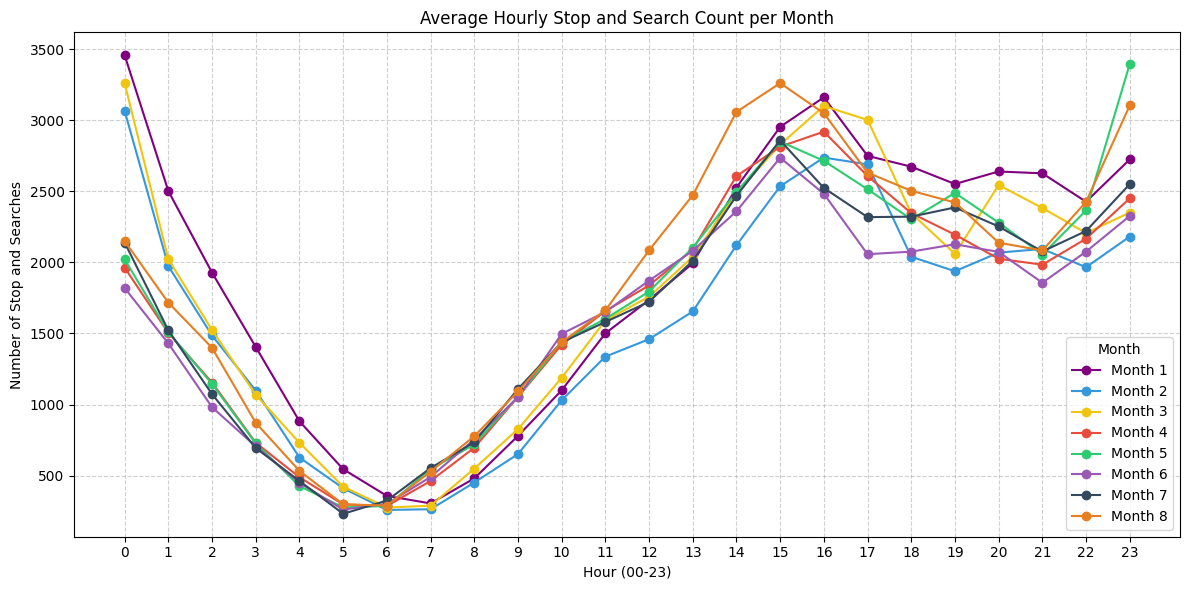

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'Time' column is in datetime format and extract the hour
imported_df['Time'] = pd.to_datetime(imported_df['Time'], format='%H:%M:%S', errors='coerce').dt.hour

# Group by Month and Time (hour) and count the occurrences
hourly_counts = imported_df.groupby(['Month', 'Time']).size().reset_index(name='Count')

# Define the color map
color_map = {
    '1': '#800080',  # สีม่วง
    '2': '#3498db',  # สีน้ำเงิน
    '3': '#f1c40f',  # สีเหลือง
    '4': '#e74c3c',  # สีแดง
    '5': '#2ecc71',  # สีเขียว
    '6': '#9b59b6', # สีม่วงอ่อน
    '7': '#34495e', # สีกรมท่า
    '8': '#e67e22'  # สีส้ม
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot a line for each month
for month in sorted(imported_df['Month'].unique()):
    month_data = hourly_counts[hourly_counts['Month'] == month]
    # Ensure all hours from 0 to 23 are present, filling missing with 0
    month_data = month_data.set_index('Time').reindex(range(24), fill_value=0).reset_index()
    plt.plot(month_data['Time'], month_data['Count'], marker='o', linestyle='-', color=color_map.get(month, 'gray'), label=f'Month {int(month)}') # Use get for safety

# plt.title('ยอดการหยุดตรวจและเรียกค้นรายชั่วโมงเฉลี่ยในแต่ละเดือน')
# plt.xlabel('ชั่วโมง (00-23)')
# plt.ylabel('จำนวนครั้งที่หยุดตรวจและเรียกค้น')
# plt.xticks(range(24)) # Set x-axis ticks to show all hours
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend(title='เดือน')
# plt.tight_layout()
# plt.show()

plt.title('Average Hourly Stop and Search Count per Month')
plt.xlabel('Hour (00-23)')
plt.ylabel('Number of Stop and Searches')
plt.xticks(range(24)) # Set x-axis ticks to show all hours
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Month')
plt.tight_layout()
plt.show()

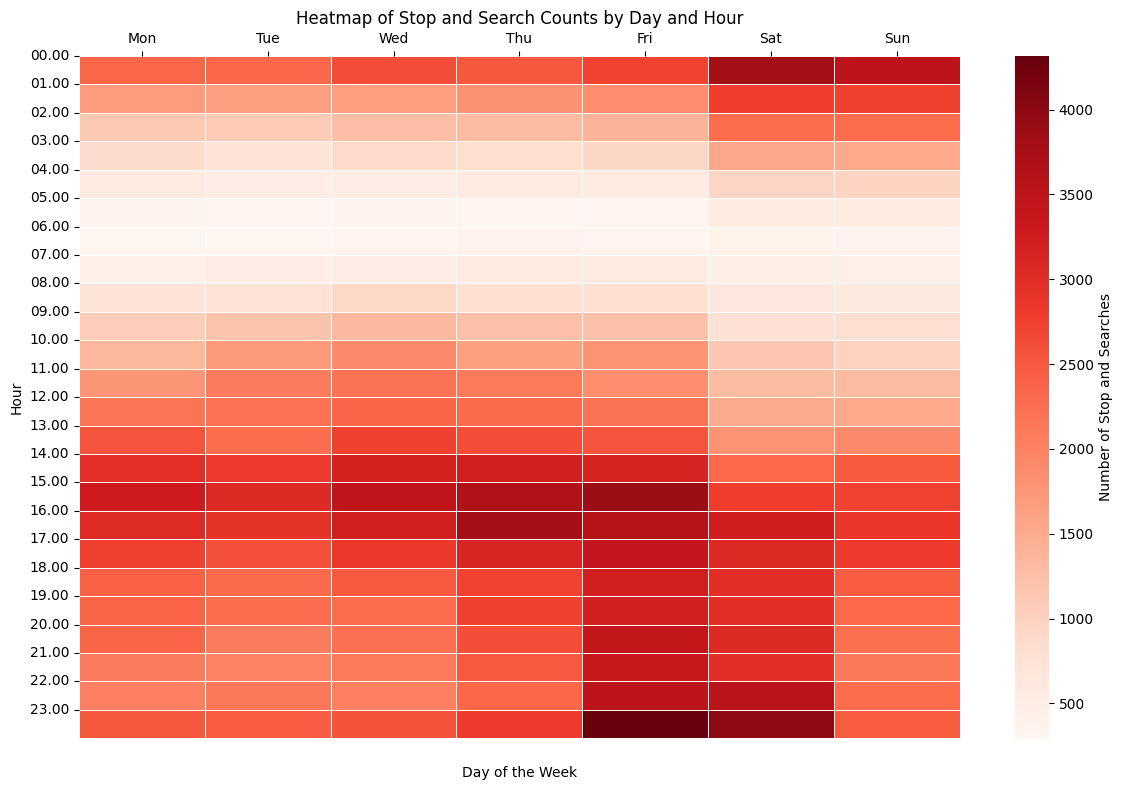

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure 'Date' column is in datetime format
# Use errors='coerce' to handle any potential parsing issues
imported_df['Date'] = pd.to_datetime(imported_df['Date'], errors='coerce')

# Extract Day of the week (Monday=0, Sunday=6) and Hour
imported_df['DayOfWeek'] = imported_df['Date'].dt.dayofweek
imported_df['Hour'] = imported_df['Time'] # Assuming 'Time' is already in hour format from previous step

# Group by DayOfWeek and Hour and count the occurrences
heatmap_data = imported_df.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)

# Define the order of days for the heatmap
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Reindex the columns to match the desired day order
heatmap_data = heatmap_data.reindex(columns=range(24), index=range(7)).fillna(0) # Ensure all hours and days are present
# Transpose the DataFrame to swap axes
heatmap_data = heatmap_data.T
heatmap_data.columns = day_order # Rename columns to day names (after transpose)


# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, cmap="Reds", fmt='d', linewidths=.5, cbar_kws={'label': 'Number of Stop and Searches'})

plt.title('Heatmap of Stop and Search Counts by Day and Hour')
plt.ylabel('Hour') # Swapped labels

# Set x-axis ticks to show days of the week and move them to the top
plt.xticks(ticks=[i + 0.5 for i in range(len(day_order))], labels=day_order, rotation=0, ha='center')

# plt.xticks(ticks=range(len(day_order)), labels=day_order, rotation=0, ha='center') # Ensure ha='center'
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False) # Move ticks and labels to the top

# Set the x-axis label and position it at the top center
ax.set_xlabel('Day of the Week', labelpad=20, loc='center') # Added labelpad and loc

hour_labels = [f"{h:02d}.00" for h in range(24)]

# Set y-axis ticks to show all hours
plt.yticks(ticks=range(24), labels=hour_labels, rotation=0)
plt.tight_layout()
plt.show()

# Looker Studio

https://lookerstudio.google.com/s/nRLGdKn3ypU